In [131]:
import pandas as pd
import numpy as np

from prince import FAMD

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt


pd.set_option('display.max_columns', 500)


# Clustering

In [82]:
preprocessed_normal_cohort_csv_path = "../../../preprocessed_normal_cohort_echo_reports.csv"

## PCA clustering
Perfrom clustering in PCA space

In [52]:
df = pd.read_csv(preprocessed_normal_cohort_csv_path)
df = df.drop('Unnamed: 0', axis=1)

#impute nan values with mode
for column in df.columns:
    series = df[column]
    if series.dtype == 'object':
        df[column] = series.fillna(series.mode()[0])
    else:
        df[column] = series.fillna(series.median())

# map strings to categorical codes
for column in df.columns:
    series = df[column]
    if series.dtype == 'object':
        df[column] = pd.Categorical(series)
        df[column] = df[column].cat.codes


In [53]:
X = df
pca = PCA().fit(X)
transformed_X, explained_variances = pca.transform(X), pca.explained_variance_ratio_

Use elbow method  to choose how many clusters features to use in the clustering algorithm

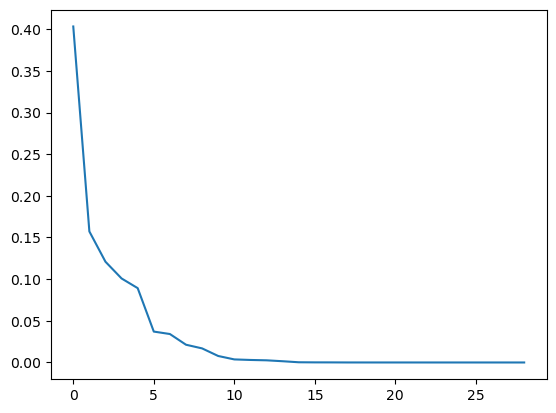

In [45]:
# plot explained variances 
plt.plot(explained_variances)
plt.show()

Find out how many cluster centers to use best

k = 2, min distance between cluster centers = 47.9737354698816
k = 2, inertia = 5432840.105899012
k = 3, min distance between cluster centers = 34.90927061214851
k = 3, inertia = 4789376.052432314
k = 4, min distance between cluster centers = 33.232888157970415
k = 4, inertia = 4317394.711193023
k = 5, min distance between cluster centers = 29.844082413802333
k = 5, inertia = 3998142.1579477172
k = 6, min distance between cluster centers = 32.487096168903946
k = 6, inertia = 3713375.921315456
k = 7, min distance between cluster centers = 31.20951497832046
k = 7, inertia = 3500277.2119800015
k = 8, min distance between cluster centers = 30.182021965989517
k = 8, inertia = 3319587.511688751
k = 9, min distance between cluster centers = 29.40351530260222
k = 9, inertia = 3161382.7576148324
k = 10, min distance between cluster centers = 29.808867504199718
k = 10, inertia = 3019831.1995589365
k = 11, min distance between cluster centers = 29.32087170419899
k = 11, inertia = 2890124.98606416

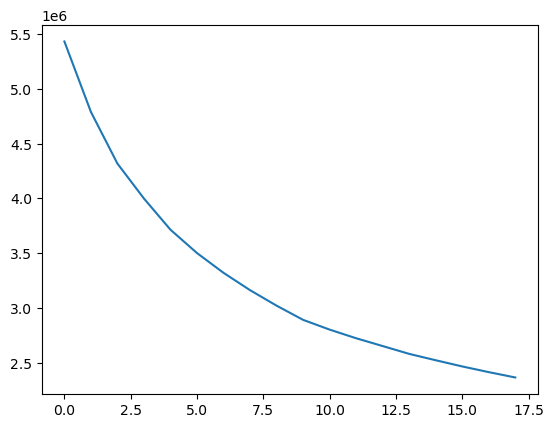

In [46]:
compressed_transformed_X = transformed_X[:, :5]

inertias = []
for i in range(2, 20):
    k_means = GaussianMixture(n_clusters=i, random_state=0).fit(compressed_transformed_X)
    inertias.append(k_means.inertia_)

    # calculate minimal distance between cluster centers
    cluster_centers = k_means.cluster_centers_
    min_distance = float('inf')
    for ci in range(len(cluster_centers)):
        for cj in range(ci+1, len(cluster_centers)):
            distance = np.linalg.norm(cluster_centers[ci] - cluster_centers[cj])
            if distance < min_distance:
                min_distance = distance
    
    print("k = {}, min distance between cluster centers = {}".format(i, min_distance))
    print("k = {}, inertia = {}".format(i, k_means.inertia_))

plt.plot(inertias)


Evaluate cluster centers.

In [77]:
k_means = KMeans(n_clusters=6, random_state=0).fit(compressed_transformed_X)
labels = k_means.labels_

# calculate cluster mean and std for each cluster
df_labeled = pd.concat([df, pd.DataFrame(labels, columns=['cluster'])], axis=1)
cluster_centers_df = df_labeled.groupby('cluster').agg(['mean', 'sum', 'count'])

pd.set_option('display.max_columns', 500)
cluster_centers_df.head(10)

Groesse_Echokardiographie                 Gewicht_Echokardiographie  \
                             mean       sum count                      mean   
cluster                                                                       
0                      180.340343  115778.5   642                 86.889097   
1                      172.293206  180046.4  1045                 72.725110   
2                      173.000756   68681.3   397                113.447607   
3                      163.971469  175285.5  1069                 61.312554   
4                      169.630926   75146.5   443                 77.148758   
5                      172.173432   93318.0   542                 77.688284   

                               BMI                Echoqualitaet               \
              sum count       mean      sum count          mean    sum count   
cluster                                                                        
0        55782.80   642  26.762617  17181.6   642      0.504673  324.0   642   
1        75997.74  1045  24.566124  25671.6  1045      0.488038  510.0  1045   
2        45038.70   397  37.861965  15031.2   397      0.173804   69.0   397   
3        65543.12  1069  22.833957  24409.5  1069      0.443405  474.0  1069   
4        34176.90   443  26.881941  11908.7   443      0.279910  124.0   443   
5        42107.05   542  26.243173  14223.8   542      0.577491  313.0   542   

        Mitralklappe               Aortenklappe                   Aorta  \
                mean     sum count         mean     sum count      mean   
cluster                                                                   
0           0.948598   609.0   642     0.962617   618.0   642  1.939252   
1           0.953110   996.0  1045     0.974163  1018.0  1045  1.963636   
2           0.967254   384.0   397     0.977330   388.0   397  1.957179   
3           0.943873  1009.0  1069     0.969130  1036.0  1069  1.980355   
4           0.943567   418.0   443     0.950339   421.0   443  1.959368   
5           0.959410   520.0   542     0.977860   530.0   542  1.933579   

                      Trikuspidalklappe               Pulmonalklappe      \
            sum count              mean     sum count           mean sum   
cluster                                                                    
0        1245.0   642          1.000000   642.0   642            0.0   0   
1        2052.0  1045          0.998086  1043.0  1045            0.0   0   
2         777.0   397          0.997481   396.0   397            0.0   0   
3        2117.0  1069          0.997194  1066.0  1069            0.0   0   
4         868.0   443          1.000000   443.0   443            0.0   0   
5        1048.0   542          1.000000   542.0   542            0.0   0   

              VenaCavaInferior               RechterVorhof                \
        count             mean     sum count          mean     sum count   
cluster                                                                    
0         642         0.985981   633.0   642      0.987539   634.0   642   
1        1045         0.984689  1029.0  1045      0.995215  1040.0  1045   
2         397         0.994962   395.0   397      1.000000   397.0   397   
3        1069         0.993452  1062.0  1069      1.000000  1069.0  1069   
4         443         0.993228   440.0   443      1.000000   443.0   443   
5         542         0.998155   541.0   542      0.994465   539.0   542   

        RechterVentrikel               LinkerVorhof               ESD_M_Mode  \
                    mean     sum count         mean     sum count       mean   
cluster                                                                        
0               0.998442   641.0   642     0.973520   625.0   642  37.294393   
1               0.997129  1042.0  1045     0.985646  1030.0  1045  34.232057   
2               1.000000   397.0   397     0.997481   396.0   397  38.405542   
3               0.998129  1067.0  1069     0.9962

## FAMD 
Mixed type dimensionality reduction.

In [189]:
# read data from csv
df = pd.read_csv(preprocessed_normal_cohort_csv_path)
df = df.drop('Unnamed: 0', axis=1)

#impute nan values with mode
for column in df.columns:
    series = df[column]
    if series.dtype == 'object':
        df[column] = series.fillna(series.mode()[0])
    else:
        df[column] = series.fillna(series.median())

# drop the single aorta replced patient
df = df.drop(df[df['Aorta'] == 'Ersetzt'].index)
# map strings to categorical

for column in df.columns:
    series = df[column]
    if series.dtype == 'object':
        df[column] = pd.Categorical(series)
        df[column] = df[column].cat.codes
        df[column] = df[column].astype('category')



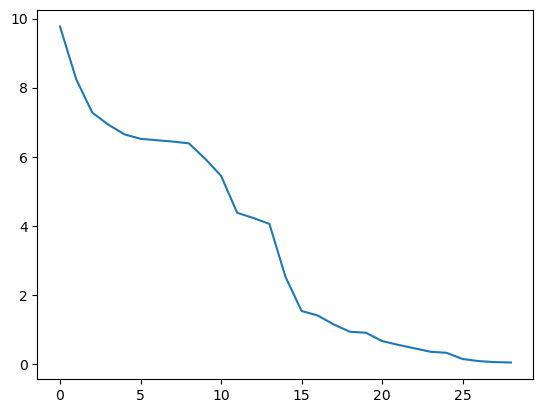

In [190]:
X = df

famd = FAMD(n_components=len(X.columns),random_state = 42).fit(X)
transformed_X, summary = famd.transform(X), famd.eigenvalues_summary
explained_variances = summary['% of variance'].apply(lambda s: float(s.replace('%', '')))

plt.plot(explained_variances)
plt.show()

Find optimal number of clusters.

k = 2, min distance = 18.253697456372294, score = 264071.88110084017
k = 3, min distance = 18.251410696921685, score = 224198.2033383673
k = 4, min distance = 5.203971859998094, score = 149634.0615066429
k = 5, min distance = 5.2023430207120285, score = 131587.69644170036
k = 6, min distance = 5.202128632057181, score = 84918.40461007043
k = 7, min distance = 5.203093478908129, score = 61524.94936940337
k = 8, min distance = 5.2108916584009695, score = -116185.52197840673
k = 9, min distance = 5.205077659645647, score = -169351.97266199643
k = 10, min distance = 5.205077659645647, score = -169788.7013502666
k = 11, min distance = 5.212543344622795, score = -192044.9452215091
k = 12, min distance = 5.205338208610655, score = -175066.39949092706
k = 13, min distance = 5.205754351118275, score = -180180.8820134965
k = 14, min distance = 5.190676753682689, score = -226818.5082679257


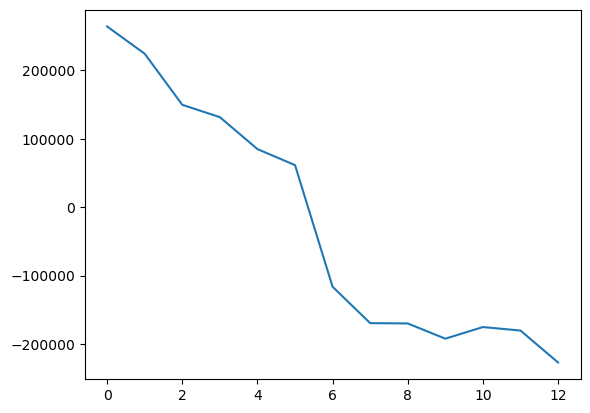

In [182]:
compressed_transformed_X = transformed_X.to_numpy()[:, :16]

scores = []
for i in range(2, 15):
    gm = GaussianMixture(n_components=i, random_state=0).fit(compressed_transformed_X)

    scores.append(gm.bic(compressed_transformed_X))
    # calculate minimal distance between cluster centers
    cluster_centers = gm.means_
    min_distance = float('inf')
    for ci in range(len(cluster_centers)):
        for cj in range(ci+1, len(cluster_centers)):
            distance = np.linalg.norm(cluster_centers[ci] - cluster_centers[cj])
            if distance < min_distance:
                min_distance = distance
    
    print("k = {}, min distance = {}, score = {}".format(i, min_distance, scores[-1]))
plt.plot(scores)
plt.show()

Evaluate cluster centers

In [191]:
gmm = GaussianMixture(n_components=6, random_state=42).fit(compressed_transformed_X)
labels = gmm.predict(compressed_transformed_X)

# calculate cluster mean and std for each cluster
df_labeled = pd.concat([df, pd.DataFrame(labels, columns=['cluster'])], axis=1)
cat_df_labeled = df_labeled.select_dtypes(exclude=['float64'])
num_df_labeled = df_labeled.select_dtypes(['float64', 'int64'])

cat_cluster_modes = cat_df_labeled.drop(columns=['Pulmonalklappe', 'Ebene']).groupby('cluster').agg(lambda series: dict(series.value_counts())[0] / series.shape[0])
num_cluster_centers_df = num_df_labeled.groupby('cluster').agg(['mean'])
num_patients_in_cluster = num_df_labeled.groupby('cluster').count()['BMI'].rename('num_patients')

cluster_infos = pd.concat([num_patients_in_cluster, cat_cluster_modes, num_cluster_centers_df], axis=1)
cluster_infos.round(2).to_csv('dim_red_cluster_infos.csv', index=False)
cluster_infos.head(10)

,num_patients,Echoqualitaet,Mitralklappe,Aortenklappe,Aorta,Trikuspidalklappe,VenaCavaInferior,RechterVorhof,RechterVentrikel,LinkerVorhof,LinkerVentrikel,RegionaleWandbewegungen,"(Groesse_Echokardiographie, mean)","(Gewicht_Echokardiographie, mean)","(BMI, mean)","(ESD_M_Mode, mean)","(ESV, mean)","(EDV, mean)","(EF, mean)","(Septum, mean)","(Hinterwand, mean)","(EDD, mean)","(LVMMI, mean)","(rTh, mean)","(LV_Fuellung, mean)","(HeartFrequency, mean)","(BloodPressure_Systole, mean)","(BloodPressure_Diastole, mean)"
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1758,0.000000,0.038090,0.020466,0.036953,0.001137,0.0,0.0,0.000569,0.009665,0.0,0.023309,171.534983,73.074482,24.725427,34.756257,37.685040,96.351024,61.113197,8.576906,7.722469,47.069170,69.773606,59.139947,59.161547,73.676906,125.911832,76.922071
1,39,0.743590,0.230769,0.307692,0.051282,0.000000,0.0,0.0,0.000000,0.025641,1.0,0.205128,172.487179,81.526923,27.410256,35.307692,37.666667,95.358974,60.102564,9.358974,8.410256,46.230769,73.512821,63.846208,60.000000,75.333333,131.589744,79.897436
2,16,0.375000,0.312500,0.187500,0.000000,0.000000,0.0,1.0,0.062500,0.625000,0.0,0.000000,175.812500,76.662500,24.631250,38.312500,43.937500,116.562500,61.687500,8.562500,7.937500,48.500000,72.375000,57.443525,59.187500,65.750000,125.500000,74.687500
3,2204,1.000000,0.053085,0.033122,0.044465,0.001815,0.0,0.0,0.002269,0.012704,0.0,0.021779,170.741243,79.940617,27.379174,35.030853,37.349183,93.388838,60.132486,8.700998,7.667877,46.358485,65.925590,59.582495,59.134755,76.538566,127.952359,77.955989
4,38,0.552632,0.078947,0.052632,0.052632,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,174.894737,72.607895,23.747368,35.105263,41.473684,99.684211,58.447368,8.236842,7.631579,47.026316,65.026316,58.401792,58.421053,73.631579,124.973684,75.394737
5,82,0.780488,0.012195,0.012195,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.012195,171.085366,82.414634,27.142683,34.219512,36.128049,92.097561,61.219512,8.945122,7.865854,46.121951,68.951220,60.538250,58.975610,79.158537,127.365854,76.048780
